In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Models import GaussianPulse as G
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities.Utils import file_parser
import matplotlib.pyplot as plt
import numpy as np
import os

h_red = Const.Planck_reduced_ev_fs
h = Const.Planck_ev_fs
light_speed = Const.Light_speed_nm_fsm1

In [3]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='yambo',activate_BeeOND=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 2,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

# Analysis of the Lifetimes

We study the lifetimes of the QP both in the equilibrium and in the NEQ regime.

## EQ Analysis

We study the distribution of the lifetimes in function of the energies of the QP in the equilibrium regime

We select a $k$-samplings

In [12]:
run_path = 'EQ_ABS'
k = '9x9x1' #'12x12x3'
run_dir = os.path.join(run_path,k)
run_dir

'EQ_ABS/9x9x1'

In [13]:
input_dir = 'DFT_analysis/kpoints_%s-nbnds_100.save'%k
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)    

SAVE folder EQ_ABS/9x9x1/SAVE already present. No operations performed.


We need to perform a convergence analysis in the NGsBlkXs and in the BndsRnXd parameters

In [53]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXd_units = 'RL'
elec_field = [1.,0.,0.]
QPkrange = [1,50,25,80]
scissor = 0.261

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -l',folder=run_dir)
inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))

NGsBlkXd = 30 # (RL) G size of the response function
BndsRnXd = [1,80] # Polarization function bands
damping = [0.05,0.05] # eV

inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
idd = 'lifetimes-ngsblkxd_%s-bndsrnxd_%s-damping_%s'%(NGsBlkXd,BndsRnXd[1],damping[0])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

NGsBlkXd = 50 # (RL) G size of the response function
BndsRnXd = [1,80] # Polarization function bands
damping = [0.05,0.05] # eV

inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
idd = 'lifetimes-ngsblkxd_%s-bndsrnxd_%s-damping_%s'%(NGsBlkXd,BndsRnXd[1],damping[0])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

NGsBlkXd = 30 # (RL) G size of the response function
BndsRnXd = [1,100] # Polarization function bands
damping = [0.05,0.05] # eV

inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
idd = 'lifetimes-ngsblkxd_%s-bndsrnxd_%s-damping_%s'%(NGsBlkXd,BndsRnXd[1],damping[0])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

8 8
Initialize a Dataset with 1 parallel tasks


In [54]:
study.runs[2]

{'label': 'Dataset',
 'run_dir': 'EQ_ABS/9x9x1',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -l',
  'folder': 'EQ_ABS/9x9x1',
  'filename': 'yambo.in',
  'arguments': ['em1d', 'life'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'SE_Threads': [0.0, ''],
   'LifeTrCG': [100.0, ''],
   'NGsBlkXd': [30, 'RL'],
   'Chimod': 'HARTREE',
   'BndsRnXd': [[1, 100], ''],
   'DmRngeXd': [[0.05, 0.05], 'eV'],
   'LongDrXd': [[1.0, 0.0, 0.0], ''],
   'QPkrange': [[1, 50, 25, 80], ''],
   'KfnQP_E': [[0.261, 1.0, 1.0], ''],
   'SE_ROLEs': 'q.qp.b',
   'SE_CPU': '2.2.16',
   'X_and_IO_ROLEs': 'q.g.k.c.v',
   'X_and_IO_CPU': '1.1.1.8.8'}},
 'name': 'lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.05'}

In [55]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of lifetimes-ngsblkxd_30-bndsrnxd_80-damping_0.05
Task [0] ended 
 
Run the task [1] 
Skip the run of lifetimes-ngsblkxd_50-bndsrnxd_80-damping_0.05
Task [1] ended 
 
Run the task [2] 
run command: mpirun -np 64 yambo -F lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.05.in -J lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.05 -C lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.05
slurm submit:  cd EQ_ABS/9x9x1 ; sbatch job_lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.05.sh
computation lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.05 is running...
computation lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.05 ended
Run performed in 04m-56s
Task [2] ended 
 


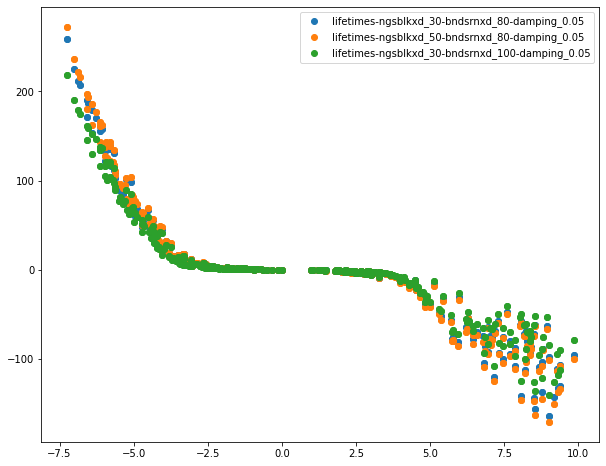

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,id in enumerate(study.ids):
    data = results[ind].data['qp']
    width_col = data['col4'] # meV
    energy_col = data['col3']
    plt.scatter(energy_col,width_col,label=id)
plt.legend()

Next, we test the stability of the results w.r.t the damping parameter

In [64]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXd_units = 'RL'
elec_field = [1.,0.,0.]
QPkrange = [1,50,25,80]
NGsBlkXd = 30 # (RL) G size of the response function
BndsRnXd = [1,100] # Polarization function bands
damping = [[0.05,0.05],[0.03,0.03],[0.01,0.01]] # eV
scissor = 0.261

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -l',folder=run_dir)
inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
for damp in damping:
    inp.set_array_variables(units='eV',DmRngeXd=damp)
    idd = 'lifetimes-ngsblkxd_%s-bndsrnxd_%s-damping_%s'%(NGsBlkXd,BndsRnXd[1],damp[0])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

8 8
Initialize a Dataset with 1 parallel tasks


In [66]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.05
Task [0] ended 
 
Run the task [1] 
Skip the run of lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.03
Task [1] ended 
 
Run the task [2] 
Skip the run of lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.01
Task [2] ended 
 


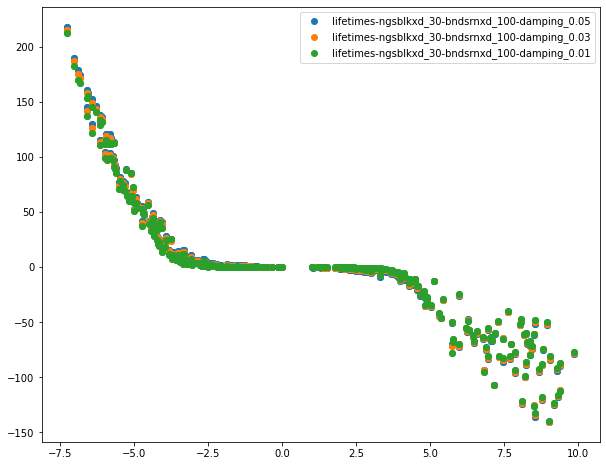

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,id in enumerate(study.ids):
    data = results[ind].data['qp']
    width_col = data['col4'] # meV
    energy_col = data['col3']
    plt.scatter(energy_col,width_col,label=id)
plt.legend()

We also compute the lifetimes in the 12x12x3 k-sampling

In [69]:
run_path = 'EQ_ABS'
k = '12x12x3'
run_dir = os.path.join(run_path,k)
run_dir

'EQ_ABS/12x12x3'

In [70]:
input_dir = 'DFT_analysis/kpoints_%s-nbnds_100.save'%k
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)    

SAVE folder EQ_ABS/12x12x3/SAVE already present. No operations performed.


In [71]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXd_units = 'RL'
elec_field = [1.,0.,0.]
QPkrange = [1,50,25,80]
NGsBlkXd = 30 # (RL) G size of the response function
BndsRnXd = [1,100] # Polarization function bands
damping = [0.03,0.03] # eV
scissor = 0.261

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -l',folder=run_dir)
inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
idd = 'lifetimes-ngsblkxd_%s-bndsrnxd_%s-damping_%s'%(NGsBlkXd,BndsRnXd[1],damping[0])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

8 8
Initialize a Dataset with 1 parallel tasks


In [74]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of lifetimes-ngsblkxd_30-bndsrnxd_100-damping_0.03
Task [0] ended 
 


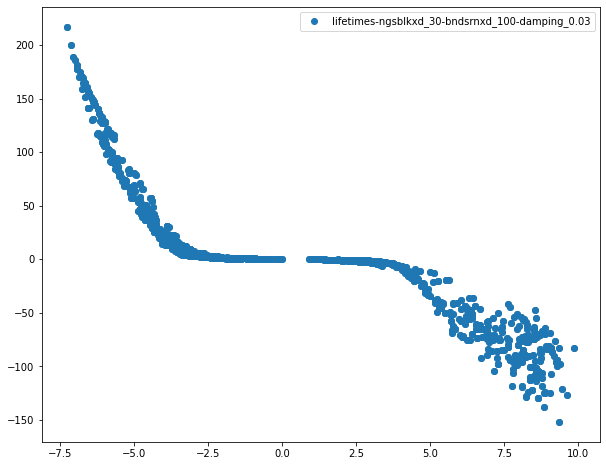

In [75]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,id in enumerate(study.ids):
    data = results[ind].data['qp']
    width_col = data['col4'] # meV
    energy_col = data['col3']
    plt.scatter(energy_col,width_col,label=id)
plt.legend()

## EQ Analysis at the K point

In order to compare with the photoemission experiment we restrict the analysis at the K point

In [4]:
run_path = 'EQ_ABS'
k = '9x9x1'
run_dir = os.path.join(run_path,k)
run_dir

'EQ_ABS/9x9x1'

In [5]:
input_dir = 'DFT_analysis/kpoints_%s-nbnds_100.save'%k
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)    

SAVE folder EQ_ABS/9x9x1/SAVE already present. No operations performed.


We need to perform a convergence analysis in the NGsBlkXs and in the BndsRnXd parameters

In [6]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXd_units = 'RL'
elec_field = [1.,0.,0.]
QPkrange = [12,12,40,60]
NGsBlkXd = 30 # (RL) G size of the response function
BndsRnXd = [1,100] # Polarization function bands
damping = [0.03,0.03] # eV
scissor = 0.261

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -l',folder=run_dir)
inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
idd = 'lifetimes-K-damping_%s'%(damping[0])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

inp = I.YamboInput('yambo -r -l',folder=run_dir)
inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
inp.set_array_variables(units='RL',RandGvec=10)
inp.set_array_variables(RandQpts=1000000)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
idd = 'lifetimes-K-rim-damping_%s'%(damping[0])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

damping = [0.005,0.005] # eV

inp = I.YamboInput('yambo -l',folder=run_dir)
inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
idd = 'lifetimes-K-damping_%s'%(damping[0])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

8 8
Initialize a Dataset with 1 parallel tasks


In [7]:
study.runs[2]

{'label': 'Dataset',
 'run_dir': 'EQ_ABS/9x9x1',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -l',
  'folder': 'EQ_ABS/9x9x1',
  'filename': 'yambo.in',
  'arguments': ['em1d', 'life'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'SE_Threads': [0.0, ''],
   'LifeTrCG': [100.0, ''],
   'NGsBlkXd': [30, 'RL'],
   'Chimod': 'HARTREE',
   'BndsRnXd': [[1, 100], ''],
   'DmRngeXd': [[0.005, 0.005], 'eV'],
   'LongDrXd': [[1.0, 0.0, 0.0], ''],
   'QPkrange': [[12, 12, 40, 60], ''],
   'KfnQP_E': [[0.261, 1.0, 1.0], ''],
   'SE_ROLEs': 'q.qp.b',
   'SE_CPU': '2.2.16',
   'X_and_IO_ROLEs': 'q.g.k.c.v',
   'X_and_IO_CPU': '1.1.1.8.8'}},
 'name': 'lifetimes-K-damping_0.005'}

In [8]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of lifetimes-K-damping_0.03
Task [0] ended 
 
Run the task [1] 
Skip the run of lifetimes-K-rim-damping_0.03
Task [1] ended 
 
Run the task [2] 
Skip the run of lifetimes-K-damping_0.005
Task [2] ended 
 


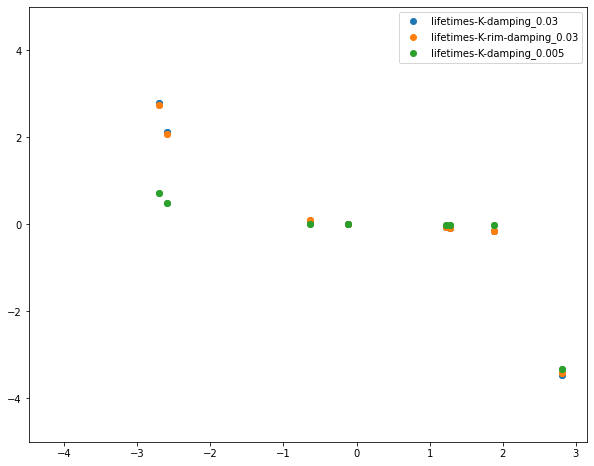

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,id in enumerate(study.ids):
    data = results[ind].data['qp']
    width_col = data['col4'] # meV
    energy_col = data['col3']
    plt.scatter(energy_col,width_col,label=id)
plt.ylim(-5,5)
plt.legend()

Probably the numbers to be compared with the 2 gaussian models of the experimental analysis are given by the
widths of the highest valence quasiparticles

## EQ Analysis with el-ph coupling

These computations are performed in the path already built and initialized by yambo_ph during the comptation
of the sl-ph ndb.

In [61]:
run_dir = 'PHONON/yambo'

In [62]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='yambo_ph',activate_BeeOND=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo_ph',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [7]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXd_units = 'RL'
elec_field = [1.,0.,0.]
QPkrange = [12,12,40,60]
NGsBlkXd = 30 # (RL) G size of the response function
BndsRnXd = [1,70] # Polarization function bands
damping = [0.03,0.03] # eV
scissor = 0.261

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_ph -g n -p fan -c ep -V All -J GKKP',folder=run_dir)
inp.set_array_variables(units='Kn',BoseTemp=300)
inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units=NGsBlkXd_units,NGsBlkXd=NGsBlkXd)
inp.set_array_variables(BndsRnXd=BndsRnXd,LongDrXd=elec_field,QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.2.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
idd = 'lifetimes-K-phonon-damping_%s'%(damping[0])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,'GKKP'])

8 4
Initialize a Dataset with 1 parallel tasks


In [13]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'PHONON/yambo',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo_ph -g n -p fan -c ep -V gen -J GKKP',
  'folder': 'PHONON/yambo',
  'filename': 'yambo.in',
  'arguments': ['gw0', 'el_ph_corr'],
  'variables': {'Nelectro': [52.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [300, 'Kn'],
   'OccTresh': [1e-05, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'SE_Threads': [0.0, ''],
   'RandQpts': [0.0, ''],
   'DysSolver': 'n',
   'GphBRnge': [[1, 70], ''],
   'ElPhModes': [[1, 18], ''],
   'QPkrange': [[12, 12, 40, 60], ''],
   'KfnQP_E': [[0.261, 1.0, 1.0], ''],
   'NGsBlkXd': [30, 'RL'],
   'BndsRnXd': [[1, 70], ''],
   'LongDrXd': [[1.0, 0.0, 0.0], ''],
   'DmRngeXd': [[0.03, 0.03], 'eV'],
   'SE_ROLEs': 'q.qp.b',
   'SE_CPU': '2.2.16',
   'X_and_IO_ROLEs': 'q.g.k.c.v',
   'X_and_IO_CPU': '1.1.1.8.8'}},
 'jobname': ['lifetimes-K-phonon-damping_0.03', 'GKKP'],
 'name': 'lifetimes-K-phonon-damping_0.03'}

In [14]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of lifetimes-K-phonon-damping_0.03
Task [0] ended 
 


In [33]:
data_ph = P.YamboOutputParser.from_file('PHONON/yambo/lifetimes-K-phonon-damping_0.03/o-lifetimes-K-phonon-damping_0.03.qp',
        extendOut=False)['qp']
data = P.YamboOutputParser.from_file('EQ_ABS/9x9x1/lifetimes-K-damping_0.03/o-lifetimes-K-damping_0.03.qp',
        extendOut=False)['qp']
eng_ph,eng = data_ph['col3'],data['E0']
width_ph,width = data_ph['col6'],data['EmE0']

Parse file PHONON/yambo/lifetimes-K-phonon-damping_0.03/o-lifetimes-K-phonon-damping_0.03.qp
Parse file EQ_ABS/9x9x1/lifetimes-K-damping_0.03/o-lifetimes-K-damping_0.03.qp


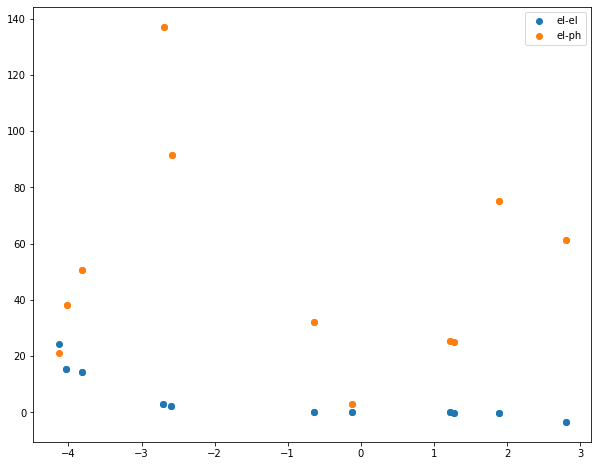

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(eng,width,label='el-el')
plt.scatter(eng_ph,width_ph,label='el-ph')
#plt.ylim(-5,5)
plt.legend()

## NEQ Analysis with el-ph coupling

We compute the lifetimes at the K point including the el-ph coupling and using the NEQ occupations computed with yambo_rt.

The analysis is performed using the new coding made in the devel-maintenance branch. The analysis is based on the usage
of yambo_rt

In [63]:
run_dir = 'PHONON/yambo'

In [64]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='yambo_rt',activate_BeeOND=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo_rt',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [65]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)
times = [0,50,100,150,200,250,300]

f_int = '1e12'

damping = [0.03,0.03] # eV
#scissor = 1. # 0.261
QPkrange = [12,12,40,60]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_rt -r -gw0 fan -V All -J GKKP',folder=run_dir)
inp.set_array_variables(units='Kn',BoseTemp=300)
#inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
inp.set_array_variables(units='RL',RandGvec=10)
inp.set_array_variables(RandQpts=1000000)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.2.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))

for t in times:
    inp.set_scalar_variables(GfnRTdb='f @ %s fs < RT_carriers/%s.RT_carriers'%(t,f_int))
    idd = 'lifetimes-K-elph-neq-damping_%s-time_%s-rim'%(damping[0],t)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,'GKKP'])

8 4
Initialize a Dataset with 1 parallel tasks


In [67]:
#study.runs[2]

In [68]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6] with the parallel task_groups [[0], [1], [2], [3], [4], [5], [6]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F lifetimes-K-elph-neq-damping_0.03-time_0-rim.in -J "lifetimes-K-elph-neq-damping_0.03-time_0-rim,GKKP" -C lifetimes-K-elph-neq-damping_0.03-time_0-rim
slurm submit:  cd PHONON/yambo ; sbatch job_lifetimes-K-elph-neq-damping_0.03-time_0-rim.sh
computation lifetimes-K-elph-neq-damping_0.03-time_0-rim is running...
computation lifetimes-K-elph-neq-damping_0.03-time_0-rim ended
Run performed in 15s
Task [0] ended 
 
Run the task [1] 
run command: mpirun -np 32 yambo_rt -F lifetimes-K-elph-neq-damping_0.03-time_50-rim.in -J "lifetimes-K-elph-neq-damping_0.03-time_50-rim,GKKP" -C lifetimes-K-elph-neq-damping_0.03-time_50-rim
slurm submit:  cd PHONON/yambo ; sbatch job_lifetimes-K-elph-neq-damping_0.03-time_50-rim.sh
computation lifetimes-K-elph-neq-damping_0.03-time_50-rim is running...
computation lifetimes-K-elph-neq-damping_0.

In [69]:
width = []
for ind,t in enumerate(times):
    width.append(results[ind].data['qp']['col6'][11])
width

[2.847434, 2.847434, 2.847434, 2.847434, 2.847434, 2.847435, 2.847434]

In [70]:
times,width

([0, 50, 100, 150, 200, 250, 300],
 [2.847434, 2.847434, 2.847434, 2.847434, 2.847434, 2.847435, 2.847434])

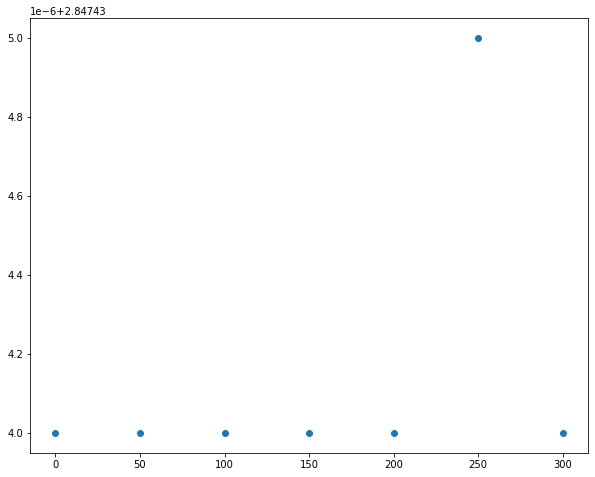

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(times,width)

https://github.com/yambo-code/yambo-tests/blob/develop/TESTS/MAIN/Si_bulk/RT/INPUTS/02_carriers_Fermi_DB



### Generation of a RT_carriers ndb with ypp

We build a the RT_carriers ndb using the tool of ypp. In this way we can fastly check which distribution
of carriers is needed in order to see some non negligible effect on the linewidth.

In [120]:
run_dir = 'PHONON/yambo'

In [121]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='ypp_rt',activate_BeeOND=True)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [143]:
RTBands = [49,54]  
Temp = 300 # K
T_ev = np.round(Temp*U.Constants.Boltzmann,3)
RTpumpNel =  1. #[0.,1.,2.]
RTpumpEhEn = [-0.118,1.21] # eV
RTtempEh = [T_ev,T_ev]

study = D.Dataset(num_tasks=1,verbose=True)
#study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('ypp_rt -rtdb f',folder=run_dir)
inp.set_array_variables(RTBands=RTBands)
inp.set_array_variables(units='K',ElecTemp=Temp)
inp.set_array_variables(units='eV',RTtempEh=RTtempEh)

#for rtpump in RTpumpNel:
#    inp.set_array_variables(RTpumpNel=rtpump)
#    idd = 'ypp-carriers-rtpumpnel=%s'%rtpump
#    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,skip=False)

inp.set_array_variables(RTpumpuNel=RTpumpNel)
inp.set_array_variables(units='eV',RTpumpEhEn=RTpumpEhEn)
idd = 'ypp-carriers-rtpumpehen_%s_%s-rtpumpnel=%s'%(RTpumpEhEn[0],RTpumpEhEn[1],RTpumpNel)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,skip=False)

Initialize a Dataset with 1 parallel tasks


In [138]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'PHONON/yambo',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'ypp_rt -rtdb f',
  'folder': 'PHONON/yambo',
  'filename': 'yambo.in',
  'arguments': ['RTDBs'],
  'variables': {'RTpumpNel': [1.0, ''],
   'RTpumpBZWd': [0.1, ''],
   'RTautotuneThr': [0.0, ''],
   'cooIn': 'rlu',
   'RTBands': [[49, 54], ''],
   'RTtempEh': [[0.026, 0.026], 'eV'],
   'ElecTemp': [300, 'K'],
   'RTpumpuNel': [1.0, ''],
   'RTpumpEhEn': [[-0.118, 1.21], 'eV']}},
 'skip': False,
 'name': 'ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0'}

In [139]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0.in -J ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0 -C ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0
slurm submit:  cd PHONON/yambo ; sbatch job_ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0.sh
computation ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0 is running...
computation ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0 ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
Run performed in 02s
Task [0] ended 
 


In [140]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='yambo_rt',activate_BeeOND=True)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [144]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

damping = [0.03,0.03] # eV
#scissor = 1. # 0.261
QPkrange = [12,12,40,60]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_rt -r -gw0 fan -V All -J GKKP',folder=run_dir)
inp.set_array_variables(units='Kn',BoseTemp=300)
#inp.set_array_variables(KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(QPkrange=QPkrange)
inp.set_array_variables(units='eV',DmRngeXd=damping)
inp.set_array_variables(units='RL',RandGvec=10)
inp.set_array_variables(RandQpts=1000000)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.2.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))

#for rtpump in RTpumpNel:
#    inp.set_scalar_variables(GfnRTdb='f @ 0.0 fs < ypp-carriers-rtpumpnel=%s/ndb.RT_carriers'%rtpump)
#    idd = 'lifetimes-K-phonon-neq-ypp-carriers-rtpumpnel_%s'%rtpump
#    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,'GKKP'],skip=False)

inp.set_scalar_variables(GfnRTdb='f @ 0.0 fs < ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0/ndb.RT_carriers')
idd = 'lifetimes-K-phonon-neq-ypp-carriers-rtpumpehen_%s_%s-rtpumpnel=%s'%(RTpumpEhEn[0],RTpumpEhEn[1],RTpumpNel)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,'GKKP'],skip=False)

8 4
Initialize a Dataset with 1 parallel tasks


In [145]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'PHONON/yambo',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo_rt -r -gw0 fan -V All -J GKKP',
  'folder': 'PHONON/yambo',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'gw0', 'gkkp', 'el_ph_corr'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [52.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [300, 'Kn'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'FFTGvecs': [6269.0, 'RL'],
   'SE_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [10, 'RL'],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'GfnQP_INTERP_NN': [1.0, ''],
   'GfnQP_INTERP_shells': [20.0, ''],
   'GfnQP_Wv_E': [0.0, 'eV'],
   'GfnQP_Wv_dos': [0.0, 'eV'],
   'GfnQP_Wc_E': [0.0, 'eV'],
   'GfnQP_Wc_dos': [0.0, 'eV'],
   'FANdEtresh': [1e-06, 'eV'],
   'DWdEtresh': [1e-06, 'eV'],
   'GDamping': [0.1, 'eV'],
   'dScStep': [0.1, 'eV'],
 

In [146]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo_rt -F lifetimes-K-phonon-neq-ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0.in -J "lifetimes-K-phonon-neq-ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0,GKKP" -C lifetimes-K-phonon-neq-ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0
slurm submit:  cd PHONON/yambo ; sbatch job_lifetimes-K-phonon-neq-ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0.sh
computation lifetimes-K-phonon-neq-ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0 is running...
computation lifetimes-K-phonon-neq-ypp-carriers-rtpumpehen_-0.118_1.21-rtpumpnel=1.0 ended
Run performed in 14s
Task [0] ended 
 


In [148]:
width = results[0].data['qp']['col6'][11]
width

2.846625

In [133]:
width = []
for ind,rtpump in enumerate(RTpumpNel):
    width.append(results[ind].data['qp']['col6'][11])
width

[1.057408, 1.057408, 1.057408]

In [135]:
bla = P.YamboRTCarriersParser('PHONON/yambo/ypp-carriers-rtpumpnel=1.0/ndb.RT_carriers')

Parse file : PHONON/yambo/ypp-carriers-rtpumpnel=1.0/ndb.RT_carriers


In [136]:
bla.get_info()

YamboRTCarriersParser variables structure
Bands used and number of k-points [49 54 12]
kpoints shape (12, 3)
E_bare shape (72,)
f_bare shape (72,)
delta_E shape (1, 72)
delta_f (1, 72)
